# Nuclie Semantic Segmentation - ICNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [ICNet](https://arxiv.org/abs/1704.08545), which is very common for image segmentation problems such as this.
- This notebook has been implemented to run on Google Colab, and it downloads data directly from Kaggle using Kaggle API Token

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 48kB/s 
    100% |████████████████████████████████| 419kB 9.7MB/s 
    100% |████████████████████████████████| 61kB 24.2MB/s 
    100% |████████████████████████████████| 3.0MB 6.1MB/s 


In [0]:
import os
import sys
import random
import warnings
import zipfile
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, BatchNormalization, ZeroPadding2D, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, MaxPooling2D, Add, Activation, AveragePooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
#TRAIN_PATH = '../input/stage1_train/'
#TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
print(tf.__version__)

2.0.0-alpha0


In [4]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [5]:
print(tf.executing_eagerly())

True


## Importing data from Kaggle to Google Colab
- Follow steps from the following link: [Link](https://www.kaggle.com/general/51898)
- Importing dataset from following competition: [Link](https://www.kaggle.com/c/data-science-bowl-2018/data)

In [0]:
setup_kaggle_api = 1

In [7]:
if setup_kaggle_api == 1:
  from google.colab import files

  #Upload Kaggle API json
  files.upload()

In [8]:
if setup_kaggle_api == 1:
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !ls ~/.kaggle
  !pip install -q kaggle
  !pip install -q kaggle-cli

kaggle.json
    100% |████████████████████████████████| 81kB 6.8MB/s 
    100% |████████████████████████████████| 5.3MB 5.8MB/s 
    100% |████████████████████████████████| 92kB 23.8MB/s 
    100% |████████████████████████████████| 51kB 20.1MB/s 


In [9]:
#Verify
!ls -l ~/.kaggle

!kaggle datasets list

#!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 66 Apr  9 14:40 kaggle.json
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          25711  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          20607  
mohansacharya/graduate-admissions                            Graduate Admissions                                   9KB  2018-12-28 10:07:14          17421  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           4100  

In [10]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       2674           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      10991            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4437           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       2705           False  
two-sigma-financial-news                           2019-07-15 23:59:00  Featured          $100,000      

In [11]:
!kaggle competitions list -s data-science-bowl-2018

ref                     deadline             category    reward  teamCount  userHasEntered  
----------------------  -------------------  --------  --------  ---------  --------------  
data-science-bowl-2018  2018-04-16 23:59:00  Featured  $100,000       3634            True  


In [12]:
if setup_kaggle_api == 1:
  !mkdir -p ~/competitions/
  !kaggle competitions download -c data-science-bowl-2018 -p competitions/
  path = '/content/competitions/'
  for file in os.listdir('/content/competitions/'):
  
    #Extract images to corresponding folders
    if '.zip' in file and 'csv' not in file:

      file_folder = re.sub('\.zip$', '/', file)
      print("Extracting files from {} to {}".format(file,path + file_folder))
      
      zip_ref = zipfile.ZipFile(path + file, 'r')
      zip_ref.extractall(path + file_folder)
      zip_ref.close()
    
    #Extract CSVs to path
    if '.zip' in file and 'csv' in file:
      
      file_folder = re.sub('\.zip$', '/', file)
      print("Extracting files from {} to {}".format(file,path))
      
      zip_ref = zipfile.ZipFile(path + file, 'r')
      zip_ref.extractall(path)
      zip_ref.close()

  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.44MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 73.7MB/s]
 55% 5.00M/9.10M [00:00<00:00, 16.5MB/s]
100% 9.10M/9.10M [00:00<00:00, 26.0MB/s]
 97% 77.0M/79.1M [00:01<00:00, 37.8MB/s]
100% 79.1M/79.1M [00:01<00:00, 60.6MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 118MB/s]
 99% 274M/276M [00:05<00:00, 56.9MB/s]
100% 276M/276M [00:05<00:00, 55.3MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 118MB/s]
Extracting files from stage1_train.zip to /content/competitions/stage1_train/
Extracting files from stage1_test.zip to /content/competitions/stage1_test/
Extracting files from stage1_sample_submission.csv.zip to /content/competitions/
Extracting files from stage1_solution.csv.zip to /content/competitions/
Extracting files from stage1_train_labels.csv.zip to /content/competitions/
Extracting files from stage2_test_final.zip to /content/competitions/stage2_test_final/
Ext

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [0]:
TRAIN_PATH = '/content/competitions/stage1_train/'
TEST_PATH = '/content/competitions/stage1_test/'

dir_path = ''


# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [14]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


In [15]:

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        
        #Overlay individual masks to create a final mask for corresponding image
        mask = np.maximum(mask, mask_)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

print('Done!')

100%|██████████| 670/670 [03:05<00:00,  3.61it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 41.72it/s]

Done!


Let's see if things look all right by drawing some random images and their associated masks.

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


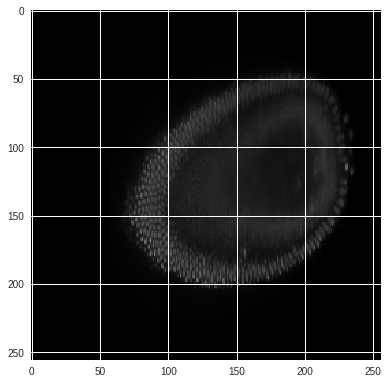

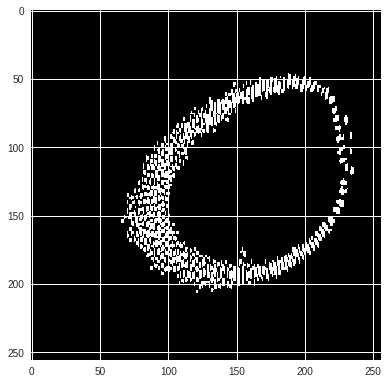

In [16]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Build and train our neural network
ICNet model based on [ICNet for Real-Time Semantic Segmentation on High-Resolution Images](https://arxiv.org/abs/1704.08545) used in [this repo](https://github.com/aitorzip/Keras-ICNet)

![](https://hszhao.github.io/projects/icnet/figures/icnet.png)

[Image Credits](https://hszhao.github.io/projects/icnet/)

In [0]:
def build_bn(width, height, n_classes, weights_path=None, train=False):
    inp = Input(shape=(height, width, 3))
    x = Lambda(lambda x: (x - 127.5)/255.0)(inp)

    # (1/2)
    y = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2)), name='data_sub2')(x)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_1_3x3_s2')(y)
    y = BatchNormalization(name='conv1_1_3x3_s2_bn')(y)
    y = Conv2D(32, 3, padding='same', activation='relu', name='conv1_2_3x3')(y)
    y = BatchNormalization(name='conv1_2_3x3_s2_bn')(y)
    y = Conv2D(64, 3, padding='same', activation='relu', name='conv1_3_3x3')(y)
    y = BatchNormalization(name='conv1_3_3x3_bn')(y)
    y_ = MaxPooling2D(pool_size=3, strides=2, name='pool1_3x3_s2')(y)
    
    y = Conv2D(128, 1, name='conv2_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv2_1_1x1_proj_bn')(y)
    y_ = Conv2D(32, 1, activation='relu', name='conv2_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(name='padding1')(y_)
    y_ = Conv2D(32, 3, activation='relu', name='conv2_1_3x3')(y_)
    y_ = BatchNormalization(name='conv2_1_3x3_bn')(y_)
    y_ = Conv2D(128, 1, name='conv2_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_increase_bn')(y_)
    y = Add(name='conv2_1')([y,y_])
    y_ = Activation('relu', name='conv2_1/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding2')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_2_3x3')(y)
    y = BatchNormalization(name='conv2_2_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_2_1x1_increase')(y)
    y = BatchNormalization(name='conv2_2_1x1_increase_bn')(y)
    y = Add(name='conv2_2')([y,y_])
    y_ = Activation('relu', name='conv2_2/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding3')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_3_3x3')(y)
    y = BatchNormalization(name='conv2_3_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_3_1x1_increase')(y)
    y = BatchNormalization(name='conv2_3_1x1_increase_bn')(y)
    y = Add(name='conv2_3')([y,y_])
    y_ = Activation('relu', name='conv2_3/relu')(y)

    y = Conv2D(256, 1, strides=2, name='conv3_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv3_1_1x1_proj_bn')(y)
    y_ = Conv2D(64, 1, strides=2, activation='relu', name='conv3_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_reduce_bn')(y_) 
    y_ = ZeroPadding2D(name='padding4')(y_)
    y_ = Conv2D(64, 3, activation='relu', name='conv3_1_3x3')(y_)
    y_ = BatchNormalization(name='conv3_1_3x3_bn')(y_)
    y_ = Conv2D(256, 1, name='conv3_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_increase_bn')(y_)
    y = Add(name='conv3_1')([y,y_])
    z = Activation('relu', name='conv3_1/relu')(y)

    # (1/4)
    y_ = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2)), name='conv3_1_sub4')(z)
    y = Conv2D(64, 1, activation='relu', name='conv3_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding5')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_2_3x3')(y)
    y = BatchNormalization(name='conv3_2_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_2_1x1_increase')(y)
    y = BatchNormalization(name='conv3_2_1x1_increase_bn')(y)
    y = Add(name='conv3_2')([y,y_])
    y_ = Activation('relu', name='conv3_2/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding6')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_3_3x3')(y)
    y = BatchNormalization(name='conv3_3_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_3_1x1_increase')(y)
    y = BatchNormalization(name='conv3_3_1x1_increase_bn')(y)
    y = Add(name='conv3_3')([y,y_])
    y_ = Activation('relu', name='conv3_3/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding7')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_4_3x3')(y)
    y = BatchNormalization(name='conv3_4_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_4_1x1_increase')(y)
    y = BatchNormalization(name='conv3_4_1x1_increase_bn')(y)
    y = Add(name='conv3_4')([y,y_])
    y_ = Activation('relu', name='conv3_4/relu')(y)

    y = Conv2D(512, 1, name='conv4_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv4_1_1x1_proj_bn')(y)
    y_ = Conv2D(128, 1, activation='relu', name='conv4_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(padding=2, name='padding8')(y_)
    y_ = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_1_3x3')(y_)
    y_ = BatchNormalization(name='conv4_1_3x3_bn')(y_)
    y_ = Conv2D(512, 1, name='conv4_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_increase_bn')(y_)
    y = Add(name='conv4_1')([y,y_])
    y_ = Activation('relu', name='conv4_1/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding9')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_2_3x3')(y)
    y = BatchNormalization(name='conv4_2_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_2_1x1_increase')(y)
    y = BatchNormalization(name='conv4_2_1x1_increase_bn')(y)
    y = Add(name='conv4_2')([y,y_])
    y_ = Activation('relu', name='conv4_2/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding10')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_3_3x3')(y)
    y = BatchNormalization(name='conv4_3_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_3_1x1_increase')(y)
    y = BatchNormalization(name='conv4_3_1x1_increase_bn')(y)
    y = Add(name='conv4_3')([y,y_])
    y_ = Activation('relu', name='conv4_3/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding11')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_4_3x3')(y)
    y = BatchNormalization(name='conv4_4_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_4_1x1_increase')(y)
    y = BatchNormalization(name='conv4_4_1x1_increase_bn')(y)
    y = Add(name='conv4_4')([y,y_])
    y_ = Activation('relu', name='conv4_4/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_5_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_5_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding12')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_5_3x3')(y)
    y = BatchNormalization(name='conv4_5_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_5_1x1_increase')(y)
    y = BatchNormalization(name='conv4_5_1x1_increase_bn')(y)
    y = Add(name='conv4_5')([y,y_])
    y_ = Activation('relu', name='conv4_5/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_6_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_6_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding13')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_6_3x3')(y)
    y = BatchNormalization(name='conv4_6_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_6_1x1_increase')(y)
    y = BatchNormalization(name='conv4_6_1x1_increase_bn')(y)
    y = Add(name='conv4_6')([y,y_])
    y = Activation('relu', name='conv4_6/relu')(y)

    y_ = Conv2D(1024, 1, name='conv5_1_1x1_proj')(y)
    y_ = BatchNormalization(name='conv5_1_1x1_proj_bn')(y_)
    y = Conv2D(256, 1, activation='relu', name='conv5_1_1x1_reduce')(y)
    y = BatchNormalization(name='conv5_1_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding14')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_1_3x3')(y)
    y = BatchNormalization(name='conv5_1_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_1_1x1_increase')(y)
    y = BatchNormalization(name='conv5_1_1x1_increase_bn')(y)
    y = Add(name='conv5_1')([y,y_])
    y_ = Activation('relu', name='conv5_1/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding15')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_2_3x3')(y)
    y = BatchNormalization(name='conv5_2_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_2_1x1_increase')(y)
    y = BatchNormalization(name='conv5_2_1x1_increase_bn')(y)
    y = Add(name='conv5_2')([y,y_])
    y_ = Activation('relu', name='conv5_2/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding16')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_3_3x3')(y)
    y = BatchNormalization(name='conv5_3_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_3_1x1_increase')(y)
    y = BatchNormalization(name='conv5_3_1x1_increase_bn')(y)
    y = Add(name='conv5_3')([y,y_])
    y = Activation('relu', name='conv5_3/relu')(y)

    h, w = y.shape[1:3].as_list()
    pool1 = AveragePooling2D(pool_size=(h,w), strides=(h,w), name='conv5_3_pool1')(y)
    pool1 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool1_interp')(pool1)
    pool2 = AveragePooling2D(pool_size=(h/2,w/2), strides=(h//2,w//2), name='conv5_3_pool2')(y)
    pool2 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool2_interp')(pool2)
    pool3 = AveragePooling2D(pool_size=(h/3,w/3), strides=(h//3,w//3), name='conv5_3_pool3')(y)
    pool3 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool3_interp')(pool3)
    pool6 = AveragePooling2D(pool_size=(h/4,w/4), strides=(h//4,w//4), name='conv5_3_pool6')(y)
    pool6 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool6_interp')(pool6)

    y = Add(name='conv5_3_sum')([y, pool1, pool2, pool3, pool6])
    y = Conv2D(256, 1, activation='relu', name='conv5_4_k1')(y)
    y = BatchNormalization(name='conv5_4_k1_bn')(y)
    aux_1 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='conv5_4_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding17')(aux_1)
    y = Conv2D(128, 3, dilation_rate=2, name='conv_sub4')(y)
    y = BatchNormalization(name='conv_sub4_bn')(y)
    y_ = Conv2D(128, 1, name='conv3_1_sub2_proj')(z)
    y_ = BatchNormalization(name='conv3_1_sub2_proj_bn')(y_)
    y = Add(name='sub24_sum')([y,y_])
    y = Activation('relu', name='sub24_sum/relu')(y)

    aux_2 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='sub24_sum_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding18')(aux_2)
    y_ = Conv2D(128, 3, dilation_rate=2, name='conv_sub2')(y)
    y_ = BatchNormalization(name='conv_sub2_bn')(y_)

    # (1)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_sub1')(x)
    y = BatchNormalization(name='conv1_sub1_bn')(y)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv2_sub1')(y)
    y = BatchNormalization(name='conv2_sub1_bn')(y)
    y = Conv2D(64, 3, strides=2, padding='same', activation='relu', name='conv3_sub1')(y)
    y = BatchNormalization(name='conv3_sub1_bn')(y)
    y = Conv2D(128, 1, name='conv3_sub1_proj')(y)
    y = BatchNormalization(name='conv3_sub1_proj_bn')(y)

    y = Add(name='sub12_sum')([y,y_])
    y = Activation('relu', name='sub12_sum/relu')(y)
    y = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='sub12_sum_interp')(y)
    y = UpSampling2D(size=(4,4))(y)
    out = Conv2D(n_classes, 1, activation='sigmoid', name='conv6_cls')(y)

    if train:
        aux_1 = Conv2D(n_classes, 1, activation='sigmoid', name='sub4_out')(aux_1)
        aux_2 = Conv2D(n_classes, 1, activation='sigmoid', name='sub24_out')(aux_2)
        model = Model(inputs=inp, outputs=[out, aux_2, aux_1])
    else:
        model = Model(inputs=inp, outputs=out)
        
    if weights_path is not None:
        model.load_weights(weights_path, by_name=True)
    return model

In [19]:
model = build_bn(width = 256, height = 256, n_classes = 1, train=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
data_sub2 (Lambda)              (None, 128, 128, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 64, 64, 32)   896         data_sub2[0][0]                  
______________________________________________________________________________________________

In [0]:
# Fit model
earlystopper = EarlyStopping(patience=50, verbose=1)
checkpointer = ModelCheckpoint('model-ICNet-initial.h5', verbose=1, save_best_only=True)

In [21]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=200, 
                    callbacks=[earlystopper, checkpointer])

Train on 536 samples, validate on 134 samples
Epoch 1/200
528/536 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.8297
Epoch 00001: val_loss improved from inf to 0.77815, saving model to model-ICNet-initial.h5
536/536 [==============================] - 29s 53ms/sample - loss: 0.4005 - accuracy: 0.8315 - val_loss: 0.7781 - val_accuracy: 0.3600
Epoch 2/200
528/536 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9299
Epoch 00002: val_loss improved from 0.77815 to 0.52909, saving model to model-ICNet-initial.h5
536/536 [==============================] - 12s 23ms/sample - loss: 0.1778 - accuracy: 0.9296 - val_loss: 0.5291 - val_accuracy: 0.7385
Epoch 3/200
528/536 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9415
Epoch 00003: val_loss improved from 0.52909 to 0.51606, saving model to model-ICNet-initial.h5
536/536 [==============================] - 12s 23ms/sample - loss: 0.1460 - accuracy: 0.9417 - val_loss: 0.5161 

In [0]:
model.save_weights("model-ICNet-trained.h5", overwrite=True)
model.save("model-ICNet-trained-model.h5", overwrite=True)


# Make predictions


In [23]:
# Predict on train, val and test
model = load_model('model-ICNet-trained-model.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 1s 8ms/sample


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


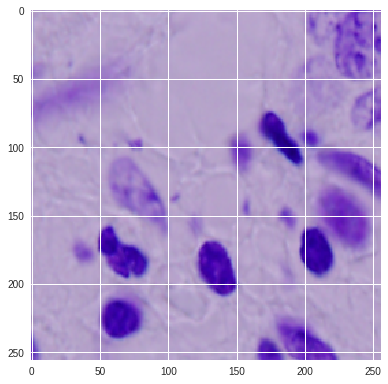

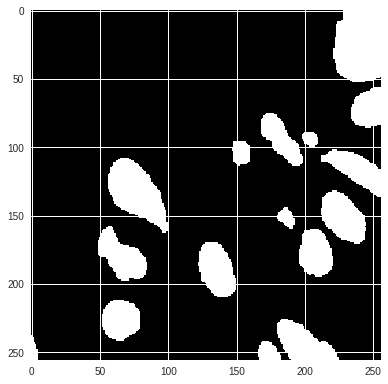

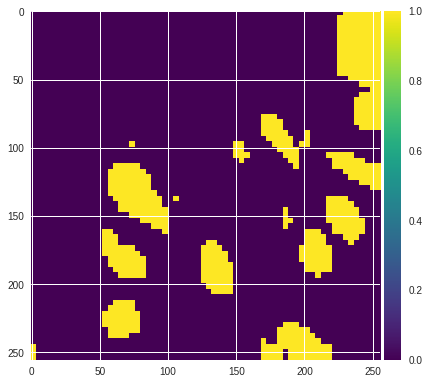

In [24]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


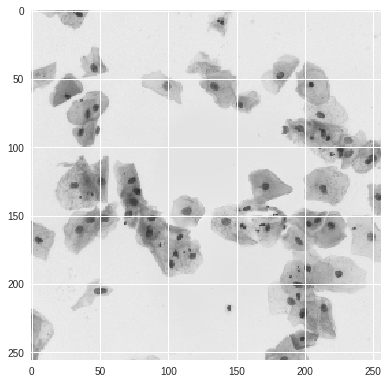

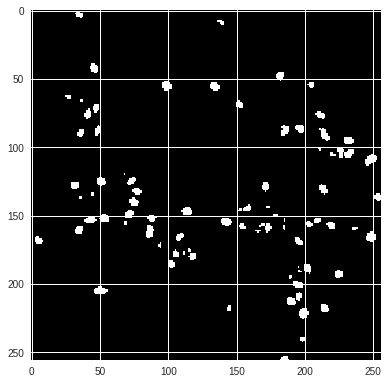

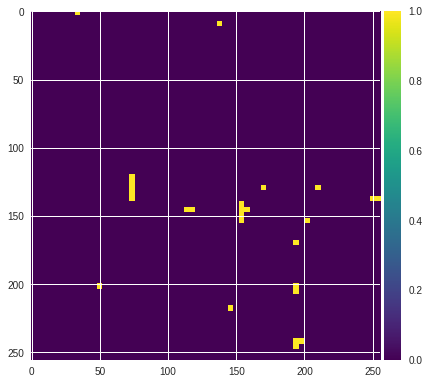

In [25]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Encode and submit our results

- [Link](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) has an excellent implementation of run-length encoding.

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

- Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

- Create submission

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)